In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import dask.config
import dask
import polars as pl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [3]:
df1 = pd.read_csv("heat_profile_data.csv",index_col=0)
df2 = pd.read_csv("heat_demand_data.csv", index_col=0)
df3 = pd.read_csv("heat_demand_by_building_data.csv",index_col=0)
df4 = pd.read_csv("COP_data.csv", index_col=0)

In [7]:
# Function to handle duplicate column names by appending numbers
def deduplicate_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [f"{dup}_{i}" if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

# Ensure unique columns for all DataFrames
for df in [df1, df2, df3, df4]:
    df = deduplicate_columns(df)
    df.reset_index(drop=True, inplace=True)

# Function to style DataFrames like SQL tables with center alignment and spacing
def style_table(df, title):
    styled_df = df.head().style.set_table_attributes("style='display: block; margin: 20px auto; width: 80%;'")\
        .set_caption(f"<b style='font-size:16px'>{title}</b>")\
        .set_properties(**{
            'background-color': '#fdfdfd',
            'color': '#333333',
            'border-color': 'black',
            'border-style': 'solid',
            'border-width': '1px',
            'text-align': 'center',
            'padding': '8px'
        })\
        .highlight_max(axis=0, color='#d4edda')\
        .highlight_min(axis=0, color='#f8d7da')
    
    return styled_df

# Display each styled table with spacing between them
display(style_table(df1, '📊 DataFrame 1 heat_profile_data'))
display(style_table(df2, '📊 DataFrame 2 heat_demand_data'))
display(style_table(df3, '📊 DataFrame 3 heat_demand_by_building_data'))
display(style_table(df4, '📊 DataFrame 4 cop_data'))

,cet_cest_timestamp,country,profile_type,water,space
0,2007-12-31T23:00:00+0100,AT,COM,66,211
1,2007-12-31T23:00:00+0100,AT,MFH,68,158
2,2007-12-31T23:00:00+0100,AT,SFH,12,177
3,2008-01-01T00:00:00+0100,AT,COM,66,211
4,2008-01-01T00:00:00+0100,AT,MFH,68,158


,utc_timestamp,cet_cest_timestamp,country,heat_demand_space,heat_demand_water,heat_demand_total
0,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000
1,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000
2,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000
3,2008-01-01T01:00:00Z,2008-01-01T02:00:00+0100,AT,9636.000000,395.000000,10031.000000
4,2008-01-01T02:00:00Z,2008-01-01T03:00:00+0100,AT,10198.000000,438.000000,10636.000000


,cet_cest_timestamp,country,building_type,water,space
0,2007-12-31T23:00:00+0100,AT,COM,167.000000,3959.000000
1,2007-12-31T23:00:00+0100,AT,MFH,124.000000,1479.000000
2,2007-12-31T23:00:00+0100,AT,SFH,53.000000,3882.000000
3,2008-01-01T00:00:00+0100,AT,COM,167.000000,3959.000000
4,2008-01-01T00:00:00+0100,AT,MFH,124.000000,1479.000000


,cet_cest_timestamp,country,source,floor,radiator,water
0,2007-12-31T23:00:00+0100,AT,ASHP,2.800000,2.240000,2.030000
1,2007-12-31T23:00:00+0100,AT,GSHP,3.720000,2.770000,2.400000
2,2007-12-31T23:00:00+0100,AT,WSHP,4.570000,3.320000,2.800000
3,2008-01-01T00:00:00+0100,AT,ASHP,2.800000,2.240000,2.030000
4,2008-01-01T00:00:00+0100,AT,GSHP,3.720000,2.770000,2.400000


In [6]:
# Rename 'profile_type' to 'building_type' in df1 so it matches df3 for merging
df1_renamed = df1.rename(columns={'profile_type': 'building_type'})

# Merge df1 and df3 on matching keys
merged_1_3 = pd.merge(
    df1_renamed,
    df3,
    on=['cet_cest_timestamp', 'country', 'building_type'],
    suffixes=('_profile', '_demand'),
    how='left'  # or 'inner' if you only want matching records
)

# Merge df2 and df4 on matching keys
merged_2_4 = pd.merge(
    df2,
    df4,
    on=['cet_cest_timestamp', 'country'],
    suffixes=('_demand', '_cop'),
    how='left'
)

In [71]:
# Function to style and display a DataFrame like an SQL table
def style_sql_table(df, title):
    styled_df = df.head(10).style.set_table_attributes("style='display: block; margin: 20px auto; width: 90%; border-collapse: collapse;'")\
        .set_caption(f"<b style='font-size:16px'>{title}</b>")\
        .set_properties(**{
            'background-color': '#fcfcfc',
            'color': '#333333',
            'border': '1px solid #999',
            'text-align': 'center',
            'padding': '6px'
        })\
        .highlight_max(axis=0, color='#d4edda')\
        .highlight_min(axis=0, color='#f8d7da')
    return styled_df

# Display the merged DataFrames like SQL tables
display(style_sql_table(merged_1_3, '📄 Merged Heat Profile & Building Demand (Top 10 Rows)'))
display(style_sql_table(merged_2_4, '📄 Merged Heat Demand & COP (Top 10 Rows)'))

,cet_cest_timestamp,country,building_type,water_profile,space_profile,water_demand,space_demand
0,2007-12-31T23:00:00+0100,AT,COM,66,211,167.000000,3959.000000
1,2007-12-31T23:00:00+0100,AT,MFH,68,158,124.000000,1479.000000
2,2007-12-31T23:00:00+0100,AT,SFH,12,177,53.000000,3882.000000
3,2008-01-01T00:00:00+0100,AT,COM,66,211,167.000000,3959.000000
4,2008-01-01T00:00:00+0100,AT,MFH,68,158,124.000000,1479.000000
5,2008-01-01T00:00:00+0100,AT,SFH,12,177,53.000000,3882.000000
6,2008-01-01T01:00:00+0100,AT,COM,83,215,210.000000,4024.000000
7,2008-01-01T01:00:00+0100,AT,MFH,70,160,129.000000,1503.000000
8,2008-01-01T01:00:00+0100,AT,SFH,15,178,64.000000,3905.000000
9,2008-01-01T02:00:00+0100,AT,COM,86,218,218.000000,4090.000000


,utc_timestamp,cet_cest_timestamp,country,heat_demand_space,heat_demand_water,heat_demand_total,source,floor,radiator,water
0,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000,ASHP,2.800000,2.240000,2.030000
1,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000,GSHP,3.720000,2.770000,2.400000
2,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000,WSHP,4.570000,3.320000,2.800000
3,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000,ASHP,2.800000,2.240000,2.030000
4,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000,GSHP,3.720000,2.770000,2.400000
5,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000,WSHP,4.570000,3.320000,2.800000
6,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000,ASHP,2.800000,2.230000,2.020000
7,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000,GSHP,3.700000,2.750000,2.390000
8,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000,WSHP,4.570000,3.310000,2.800000
9,2008-01-01T01:00:00Z,2008-01-01T02:00:00+0100,AT,9636.000000,395.000000,10031.000000,ASHP,2.780000,2.210000,2.020000



Merged DataFrame (source and building_type):
         cet_cest_timestamp country source building_type
0  2007-12-31T23:00:00+0100      AT   ASHP           COM
1  2007-12-31T23:00:00+0100      AT   ASHP           MFH
2  2007-12-31T23:00:00+0100      AT   ASHP           SFH
3  2007-12-31T23:00:00+0100      AT   GSHP           COM
4  2007-12-31T23:00:00+0100      AT   GSHP           MFH

Cross-tabulation between building_type and source:
source            ASHP     GSHP     WSHP
building_type                           
COM            3681524  3681524  3681524
MFH            3681524  3681524  3681524
SFH            3681524  3681524  3681524

Chi-Square Statistic: 0.0
P-Value: 1.0
Degrees of Freedom: 4
Expected Counts: 
[[3681524. 3681524. 3681524.]
 [3681524. 3681524. 3681524.]
 [3681524. 3681524. 3681524.]]


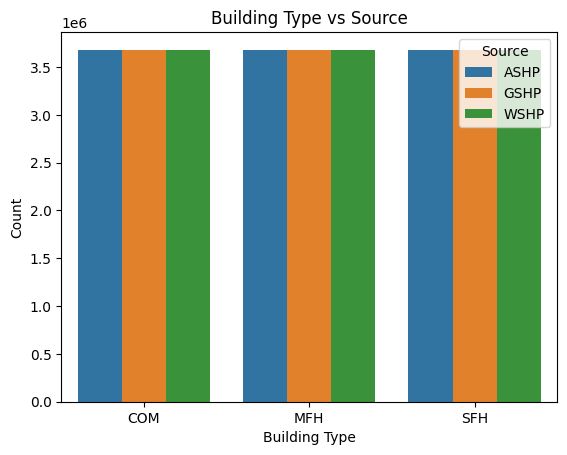

In [ ]:
from scipy.stats import chi2_contingency

# 1. Merge the DataFrames df5 and df6 on 'cet_cest_timestamp' and 'country'
df5_relevant = merged_2_4[['cet_cest_timestamp', 'country', 'source']]
df6_relevant = merged_1_3[['cet_cest_timestamp', 'country', 'building_type']]

# Merge on common columns
merged_df = pd.merge(df5_relevant, df6_relevant, on=['cet_cest_timestamp', 'country'], how='inner')

# Display merged DataFrame for verification
print("\nMerged DataFrame (source and building_type):")
print(merged_df.head())

# 2. Create a cross-tabulation between building_type and source
relationship_table = pd.crosstab(merged_df['building_type'], merged_df['source'])

# Display the relationship table
print("\nCross-tabulation between building_type and source:")
print(relationship_table)

# 3. Perform Chi-Square Test of Independence
chi2, p_value, dof, expected = chi2_contingency(relationship_table)

# Print the results of the chi-square test
print(f"\nChi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Counts: \n{expected}")

# 4. Visualize the relationship using a countplot
sns.countplot(data=merged_df, x='building_type', hue='source')
plt.title('Building Type vs Source')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()


Merged DataFrame preview:
         cet_cest_timestamp country source building_type  water_demand  \
0  2007-12-31T23:00:00+0100      AT   ASHP           COM         167.0   
1  2007-12-31T23:00:00+0100      AT   ASHP           MFH         124.0   
2  2007-12-31T23:00:00+0100      AT   ASHP           SFH          53.0   
3  2007-12-31T23:00:00+0100      AT   GSHP           COM         167.0   
4  2007-12-31T23:00:00+0100      AT   GSHP           MFH         124.0   

   space_demand  total_usage  
0        3959.0       4126.0  
1        1479.0       1603.0  
2        3882.0       3935.0  
3        3959.0       4126.0  
4        1479.0       1603.0  

Country vs Building Type:
building_type     COM     MFH     SFH
country                              
AT             394449  394449  394449
BE             394449  394449  394449
BG             394449  394449  394449
CH             394449  394449  394449
CZ             394449  394449  394449
DE             394449  394449  394449
DK         

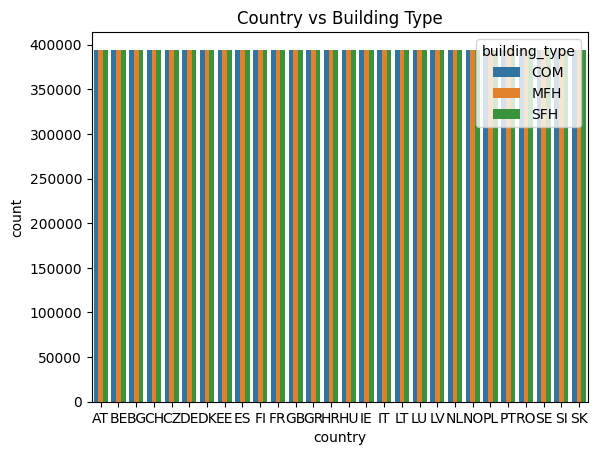

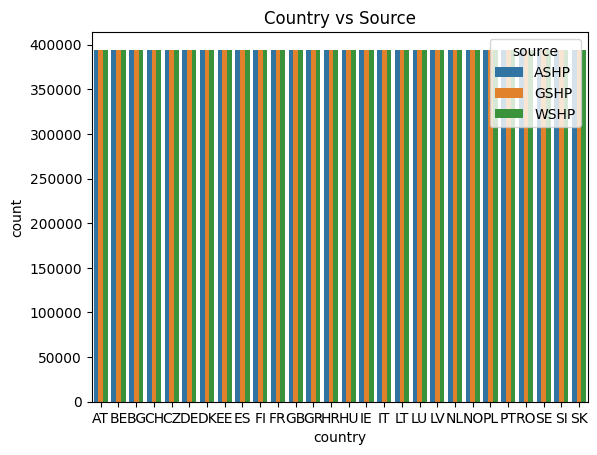

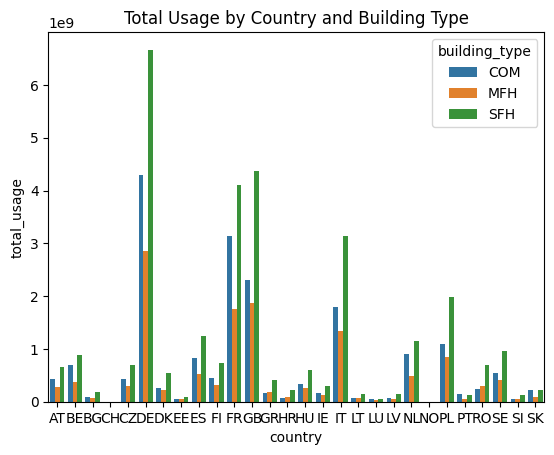

In [7]:
# Merge df5 and df6 on 'cet_cest_timestamp' and 'country'
df5_relevant = merged_2_4[['cet_cest_timestamp', 'country', 'source']]
df6_relevant = merged_1_3[['cet_cest_timestamp', 'country', 'building_type', 'water_demand', 'space_demand']]

merged_df = pd.merge(df5_relevant, df6_relevant, on=['cet_cest_timestamp', 'country'], how='inner')

# Create a 'total_usage' column
merged_df['total_usage'] = merged_df['water_demand'] + merged_df['space_demand']

# Check merged DataFrame
print("\nMerged DataFrame preview:")
print(merged_df.head())

# 📊 Cross-tab country vs building_type
ct_bt = pd.crosstab(merged_df['country'], merged_df['building_type'])
print("\nCountry vs Building Type:")
print(ct_bt)

# Chi-Square Test for country vs building_type
chi2_bt, p_bt, dof_bt, expected_bt = chi2_contingency(ct_bt)
print(f"\nChi-Square Stat: {chi2_bt}, p-value: {p_bt}")

# 📊 Cross-tab country vs source
ct_source = pd.crosstab(merged_df['country'], merged_df['source'])
print("\nCountry vs Source:")
print(ct_source)

# Chi-Square Test for country vs source
chi2_src, p_src, dof_src, expected_src = chi2_contingency(ct_source)
print(f"\nChi-Square Stat: {chi2_src}, p-value: {p_src}")

# 📊 Visualize: Country vs Building Type
sns.countplot(data=merged_df, x='country', hue='building_type')
plt.title('Country vs Building Type')
plt.show()

# 📊 Visualize: Country vs Source
sns.countplot(data=merged_df, x='country', hue='source')
plt.title('Country vs Source')
plt.show()

# 📊 Aggregate total_usage by country and building_type
usage_summary = merged_df.groupby(['country', 'building_type'])['total_usage'].sum().reset_index()

# 📊 Visualize: total_usage by country and building_type
sns.barplot(data=usage_summary, x='country', y='total_usage', hue='building_type')
plt.title('Total Usage by Country and Building Type')
plt.show()

In [8]:
df_merged = pd.merge(
    merged_1_3,
    merged_2_4[['cet_cest_timestamp', 'country', 'heat_demand_water', 'heat_demand_space', 'heat_demand_total']],
    on=['cet_cest_timestamp', 'country'],
    how='left'
)

                           heat_demand_total
cet_cest_timestamp                          
2007-12-31 00:00:00+00:00        9664.000000
2008-01-01 00:00:00+00:00       14137.500000
2008-01-02 00:00:00+00:00       14591.375000
2008-01-03 00:00:00+00:00       14704.708333
2008-01-04 00:00:00+00:00       14494.083333
ARIMA MSE for COM in AT: 30209898.28


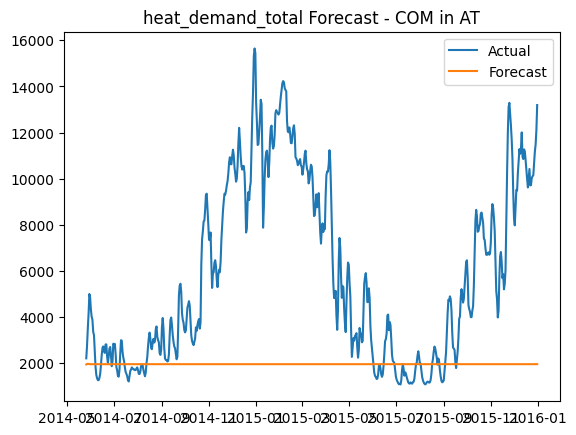

                           heat_demand_water
cet_cest_timestamp                          
2007-12-31 00:00:00+00:00         344.000000
2008-01-01 00:00:00+00:00         999.416667
2008-01-02 00:00:00+00:00         996.750000
2008-01-03 00:00:00+00:00        1000.166667
2008-01-04 00:00:00+00:00         995.375000
ARIMA MSE for MFH in AT: 1497.89


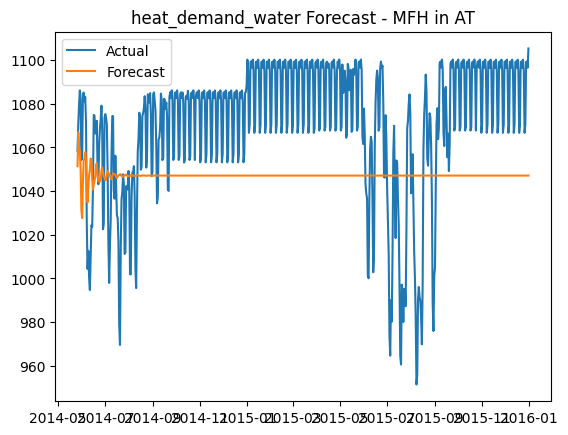

In [9]:
def time_series_forecasting(df, country='AT', building_type='COM', target_column='heat_demand_total'):
    # Check if the target column exists in the DataFrame
    if target_column not in df.columns:
        print(f"Column '{target_column}' not found in the dataset.")
        return

    # Filter for specific country and building type
    filtered_df = df[(df['country'] == country) & (df['building_type'] == building_type)][['cet_cest_timestamp', target_column]].dropna()

    if filtered_df.empty:
        print(f"No data for {building_type} in {country}.")
        return

    # Convert cet_cest_timestamp to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(filtered_df['cet_cest_timestamp']):
        filtered_df['cet_cest_timestamp'] = pd.to_datetime(filtered_df['cet_cest_timestamp'], utc=True)

    # Set index and resample
    filtered_df = filtered_df.set_index('cet_cest_timestamp').sort_index()
    ts_data = filtered_df.resample('D').mean()

    print(ts_data.head())  # sanity check

    train_size = int(len(ts_data) * 0.8)
    train, test = ts_data[:train_size], ts_data[train_size:]

    if len(train) < 10 or len(test) == 0:
        print("Not enough data points for ARIMA.")
        return

    try:
        model = ARIMA(train, order=(5, 1, 0))
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
        mse = mean_squared_error(test, predictions)
        print(f"ARIMA MSE for {building_type} in {country}: {mse:.2f}")
        plt.plot(test, label='Actual')
        plt.plot(predictions, label='Forecast')
        plt.title(f'{target_column} Forecast - {building_type} in {country}')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error fitting ARIMA: {e}")


# Call it
time_series_forecasting(df_merged, country='AT', building_type='COM', target_column='heat_demand_total')
time_series_forecasting(df_merged, country='AT', building_type='MFH', target_column='heat_demand_water')


Merged DataFrame preview:
         cet_cest_timestamp country source building_type  water_demand  \
0  2007-12-31T23:00:00+0100      AT   ASHP           COM         167.0   
1  2007-12-31T23:00:00+0100      AT   ASHP           MFH         124.0   
2  2007-12-31T23:00:00+0100      AT   ASHP           SFH          53.0   
3  2007-12-31T23:00:00+0100      AT   GSHP           COM         167.0   
4  2007-12-31T23:00:00+0100      AT   GSHP           MFH         124.0   

   space_demand  total_usage  
0        3959.0       4126.0  
1        1479.0       1603.0  
2        3882.0       3935.0  
3        3959.0       4126.0  
4        1479.0       1603.0  

Country vs Building Type:
building_type     COM     MFH     SFH
country                              
AT             394449  394449  394449
BE             394449  394449  394449
BG             394449  394449  394449
CH             394449  394449  394449
CZ             394449  394449  394449
DE             394449  394449  394449
DK         

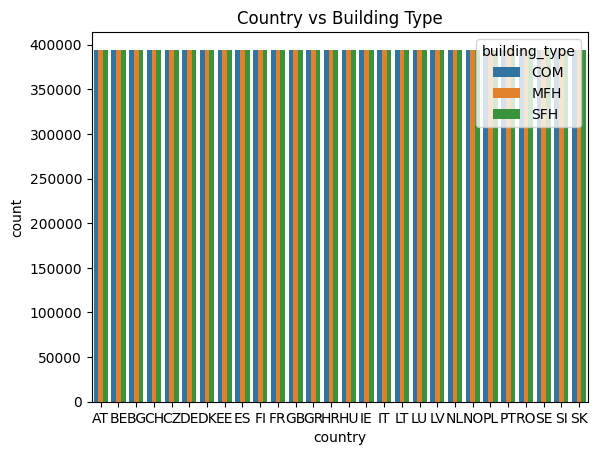

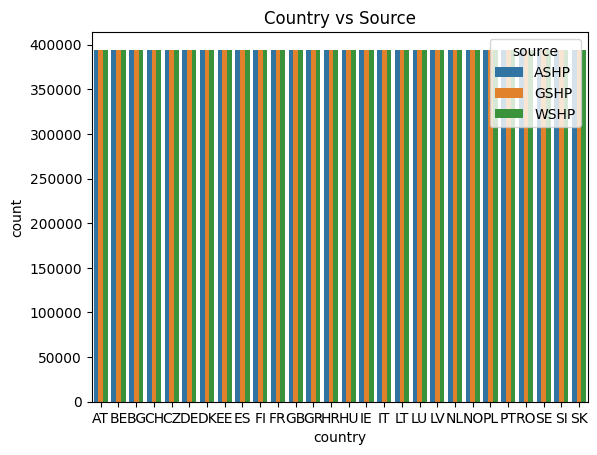

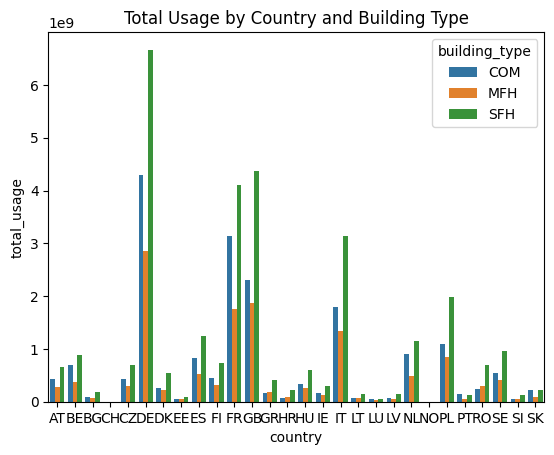

In [10]:
# Merge df5 and df6 on 'cet_cest_timestamp' and 'country'
df5_relevant = merged_2_4[['cet_cest_timestamp', 'country', 'source']]
df6_relevant = merged_1_3[['cet_cest_timestamp', 'country', 'building_type', 'water_demand', 'space_demand']]

merged_df = pd.merge(df5_relevant, df6_relevant, on=['cet_cest_timestamp', 'country'], how='inner')

# Create a 'total_usage' column
merged_df['total_usage'] = merged_df['water_demand'] + merged_df['space_demand']

# Check merged DataFrame
print("\nMerged DataFrame preview:")
print(merged_df.head())

# 📊 Cross-tab country vs building_type
ct_bt = pd.crosstab(merged_df['country'], merged_df['building_type'])
print("\nCountry vs Building Type:")
print(ct_bt)

# Chi-Square Test for country vs building_type
chi2_bt, p_bt, dof_bt, expected_bt = chi2_contingency(ct_bt)
print(f"\nChi-Square Stat: {chi2_bt}, p-value: {p_bt}")

# 📊 Cross-tab country vs source
ct_source = pd.crosstab(merged_df['country'], merged_df['source'])
print("\nCountry vs Source:")
print(ct_source)

# Chi-Square Test for country vs source
chi2_src, p_src, dof_src, expected_src = chi2_contingency(ct_source)
print(f"\nChi-Square Stat: {chi2_src}, p-value: {p_src}")

# 📊 Visualize: Country vs Building Type
sns.countplot(data=merged_df, x='country', hue='building_type')
plt.title('Country vs Building Type')
plt.show()

# 📊 Visualize: Country vs Source
sns.countplot(data=merged_df, x='country', hue='source')
plt.title('Country vs Source')
plt.show()

# 📊 Aggregate total_usage by country and building_type
usage_summary = merged_df.groupby(['country', 'building_type'])['total_usage'].sum().reset_index()

# 📊 Visualize: total_usage by country and building_type
sns.barplot(data=usage_summary, x='country', y='total_usage', hue='building_type')
plt.title('Total Usage by Country and Building Type')
plt.show()

In [11]:
# Work on a copy to avoid modifying original df_merged
df = df_merged.copy()
df_merged.head()
# Ensure datetime is in the correct format
df['cet_cest_timestamp'] = pd.to_datetime(df['cet_cest_timestamp'], utc=True)

# Extract temporal features
df['hour_of_day'] = df['cet_cest_timestamp'].dt.hour
df['day_of_week'] = df['cet_cest_timestamp'].dt.dayofweek
df['month'] = df['cet_cest_timestamp'].dt.month
df['year'] = df['cet_cest_timestamp'].dt.year

# Assign season based on month
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['season'] = df['month'].map(season_map)

# Lag features for demand and COP (if available)
df['lag_heat_demand_space'] = df['heat_demand_space'].shift(1)
df['lag_heat_demand_water'] = df['heat_demand_water'].shift(1)
df['lag_total_consumption'] = df['heat_demand_total'].shift(1)

# Calculate COP if missing
if 'cop' not in df.columns:
    df['cop'] = df['heat_demand_space'] / df['heat_demand_total']

df['lag_cop'] = df['cop'].shift(1)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

# Encode categorical variables safely
categorical_columns = ['building_type', 'country', 'source', 'season']
existing_categoricals = [col for col in categorical_columns if col in df.columns]

df = pd.get_dummies(df, columns=existing_categoricals, drop_first=True)

# Define the target variable (dependent) and features (independent)
target_columns = ['heat_demand_space', 'heat_demand_water', 'heat_demand_total', 'cop']
X = df.drop(columns=target_columns)
y = df[target_columns]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Training Linear Regression...
  Linear Regression MSE: 292735.93, R^2: 1.00


C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


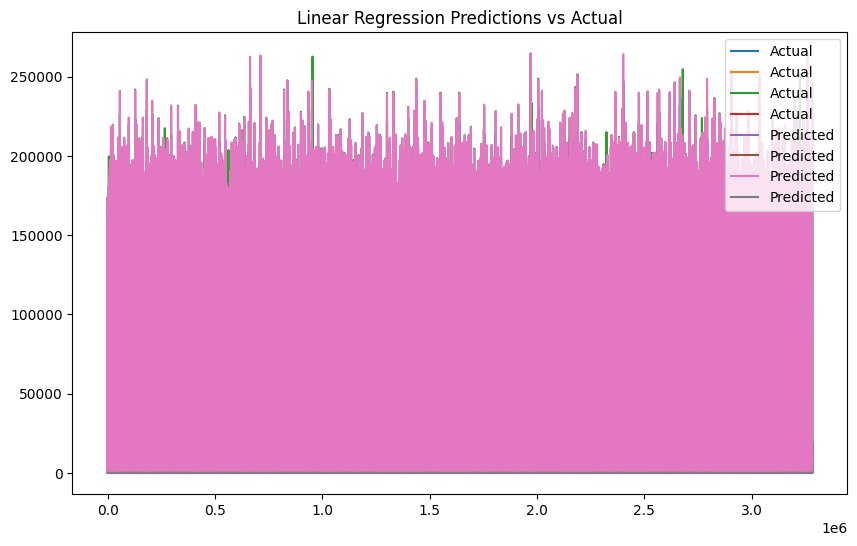

Training Ridge Regression...
  Ridge Regression MSE: 292735.93, R^2: 1.00


C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


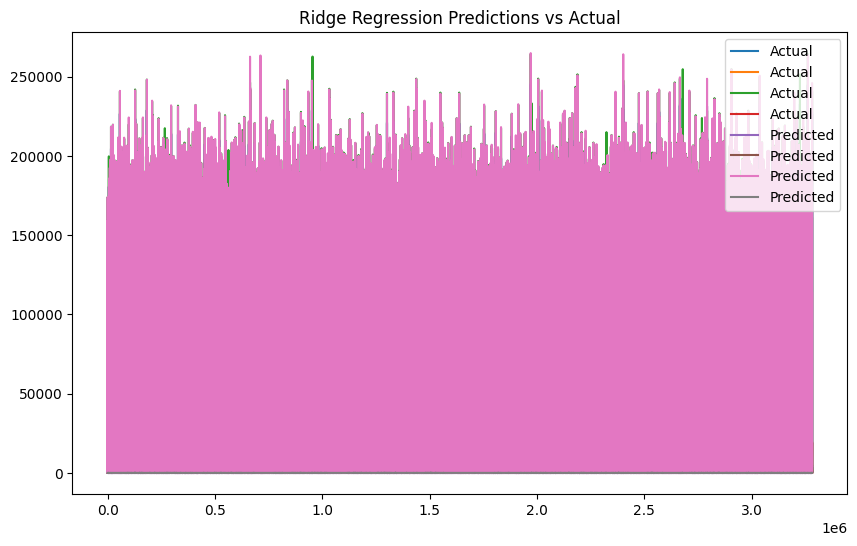

Training Lasso Regression...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.188e+11, tolerance: 4.687e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.693e+10, tolerance: 1.082e+10
  model = cd_fast.enet_coordinate_descent(


  Lasso Regression MSE: 292757.74, R^2: 0.90


C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


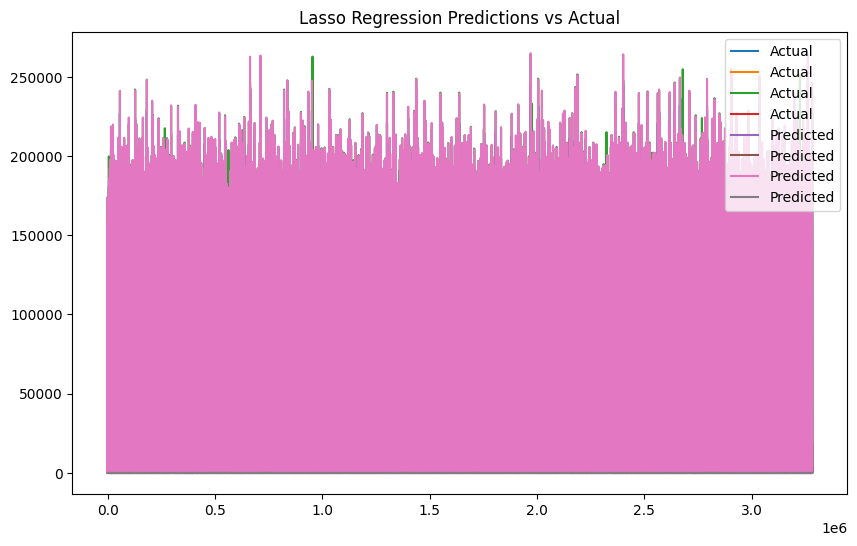

In [12]:
# Ensure that X_train and X_test have the same columns by re-aligning the columns after one-hot encoding
X_train_clean = X_train.select_dtypes(include=[np.number])  # Only numeric columns
X_test_clean = X_test.select_dtypes(include=[np.number])    # Only numeric columns

# Re-align columns to ensure they match
X_train_clean, X_test_clean = X_train_clean.align(X_test_clean, join='inner', axis=1)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

# Fit models and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_clean, y_train)
    y_pred = model.predict(X_test_clean)
    
    # Calculate MSE and R^2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"  {model_name} MSE: {mse:.2f}, R^2: {r2:.2f}")
    
    # Feature Importances (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        feature_names = X_train_clean.columns
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        
        print(importance_df.head())

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{model_name} Predictions vs Actual")
    plt.legend()
    plt.show()


Training Linear Regression...
  Linear Regression MSE (heat_demand_space): 425705.37, R^2: 1.00


C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


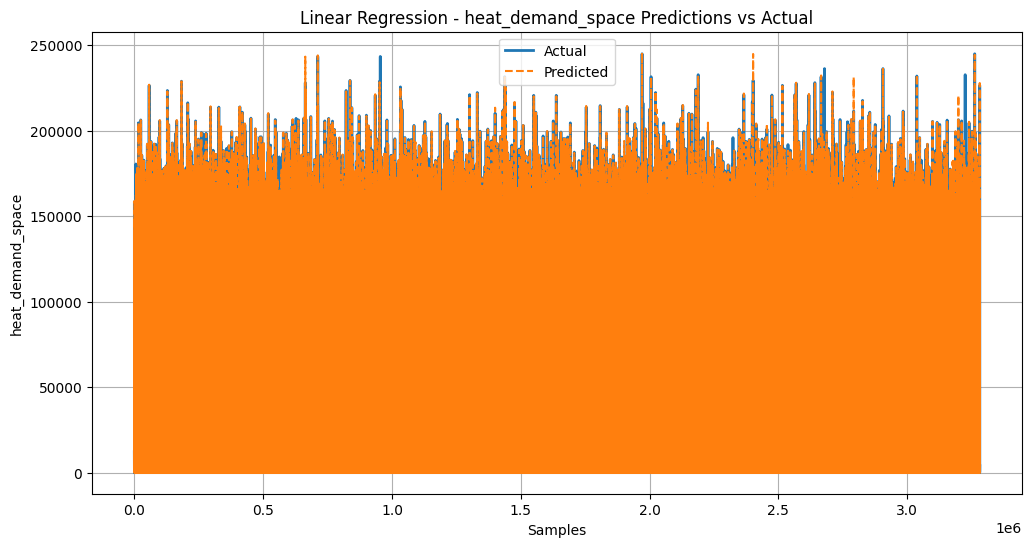

Training Ridge Regression...
  Ridge Regression MSE (heat_demand_space): 425705.37, R^2: 1.00


C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


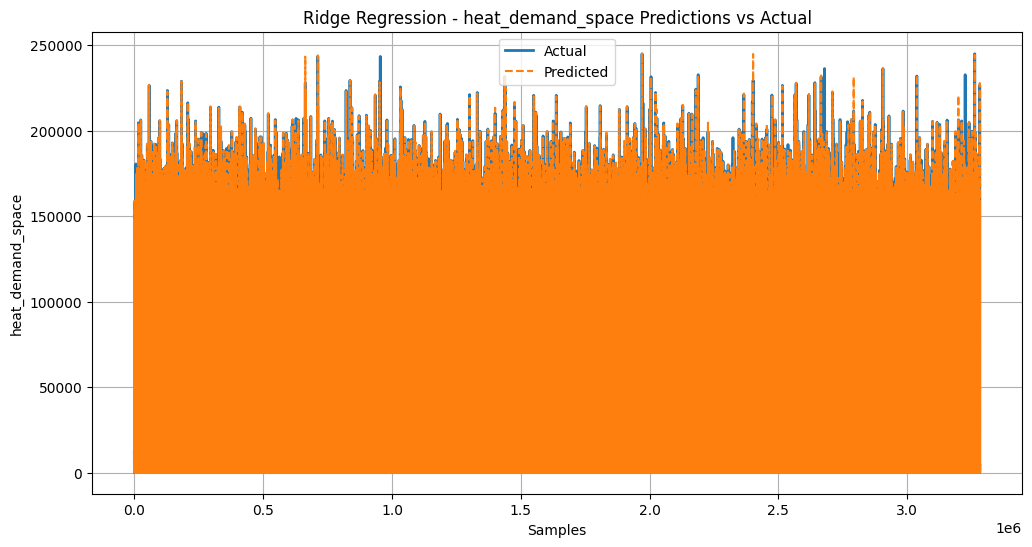

Training Lasso Regression...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.188e+11, tolerance: 4.687e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.693e+10, tolerance: 1.082e+10
  model = cd_fast.enet_coordinate_descent(


  Lasso Regression MSE (heat_demand_space): 425720.81, R^2: 1.00


C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


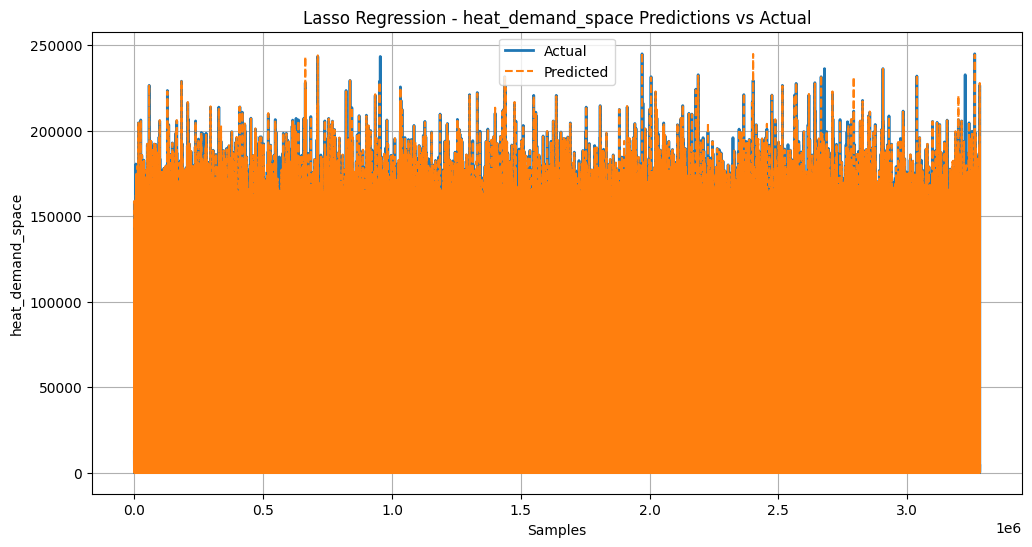

In [13]:
# Pick a target column to plot
target_col = 'heat_demand_space'

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_clean, y_train)
    y_pred = model.predict(X_test_clean)

    # Calculate MSE and R^2 for selected target
    mse = mean_squared_error(y_test[target_col], y_pred[:, y_test.columns.get_loc(target_col)])
    r2 = r2_score(y_test[target_col], y_pred[:, y_test.columns.get_loc(target_col)])

    print(f"  {model_name} MSE ({target_col}): {mse:.2f}, R^2: {r2:.2f}")

    # Plot Actual vs Predicted for this target
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[target_col].values, label='Actual', linewidth=2)
    plt.plot(y_pred[:, y_test.columns.get_loc(target_col)], label='Predicted', linestyle='--')
    plt.title(f"{model_name} - {target_col} Predictions vs Actual")
    plt.xlabel('Samples')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.show()